In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [68]:
!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-5.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-6.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-7.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-8.jpeg


In [ ]:
!pip install ultralytics
!pip install super-gradients

In [34]:
!pip install git+https://github.com/facebookresearch/segment-anything.git -q
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

^C
ERROR: Operation cancelled by user



KeyboardInterrupt



In [64]:
import numpy as np
from ultralytics import YOLO
import cv2
import math
import torch
import matplotlib.pyplot as plt
from super_gradients.training import models
import random

In [ ]:
# yolo_nas_l = models.get("yolo_nas_l", pretrained_weights="coco")

# yolo_nas_l.predict("/kaggle/input/images/images.jpg").show()
# import super_gradients
# yolo_nas = super_gradients.training.models.get("yolo_nas_pose_l", pretrained_weights="coco_pose").cuda()
# model_predictions  = yolo_nas.predict("/kaggle/input/images/images.jpg", conf=0.5).show()
# #detections = model_predictions.save('kaggle/working')
# model_pred = yolo_nas_l.predict("/kaggle/input/images/images.jpg", conf=0.5)
# # #model_pred._images_prediction_lst = list(model_pred._images_prediction_lst)
# # bboxes_xyxy = model_pred[0].prediction.bboxes_xyxy.tolist()
# # confidence = model_pred[0].prediction.confidence.tolist()
# # labels = model_pred[0].prediction.labels.tolist()

[2024-02-06 12:22:53] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-02-06 12:22:53] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l
[2024-02-06 12:22:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


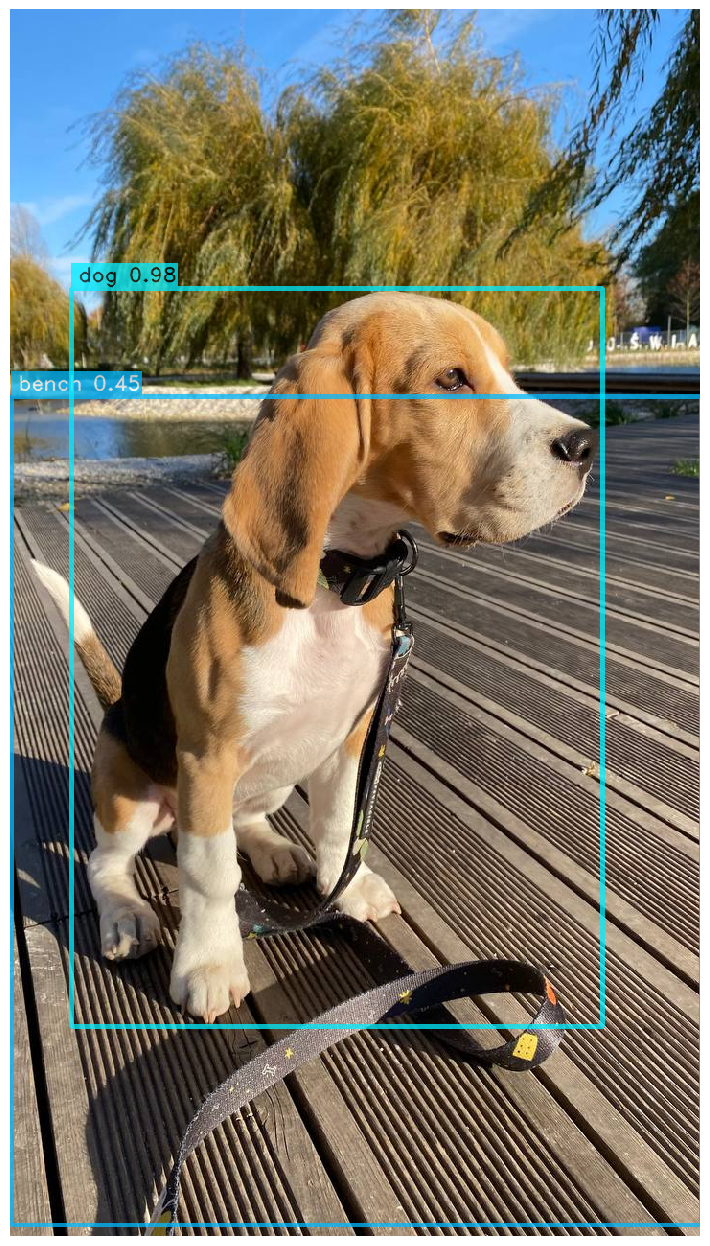

[2024-02-06 12:22:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


In [69]:
image_path = '/kaggle/working/dog-6.jpeg'

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

model = models.get('yolo_nas_l', pretrained_weights="coco")
model.predict(image, conf=0.25).show()

conf_threshold = 0.25
detection_pred = model.predict(image_path, conf=conf_threshold)
# detections = detection_pred.save('/kaggle/input/images')

In [70]:
detection_pred = model.predict(image_path, conf=conf_threshold )
# .save('/kaggle/input/images/images.jpg')

bboxes_xyxy = detection_pred.prediction.bboxes_xyxy.tolist()
confidence = detection_pred.prediction.confidence.tolist()
labels = detection_pred.prediction.labels.tolist()

[2024-02-06 12:23:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


sam helper functions to show mask details

In [71]:
detection_pred.save('/kaggle/working/dog-6.jpeg')

In [73]:
def show_mask(mask, ax, random_color=False):
    if random_color:
      color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
      color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=365):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', maker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

Here is yolo-nas with the addition of the segmentation using SAM model

In [74]:
classNames = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat",
          "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
          "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella",
          "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat",
          "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup",
          "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli",
          "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa", "pottedplant", "bed",
          "diningtable", "toilet", "tvmonitor", "laptop", "mouse", "remote", "keyboard", "cell phone",
          "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
          "teddy bear", "hair drier", "toothbrush"
        ]

In [ ]:
!nvidia-smi

In [ ]:
# !pip install ultralytics install super-gradients -q
# !pip install git+https://github.com/facebookresearch/segment-anything.git -q
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [75]:
# SAM Model for masking
sam_checkpoint = 'sam_vit_h_4b8939.pth'
model_type = "vit_h"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

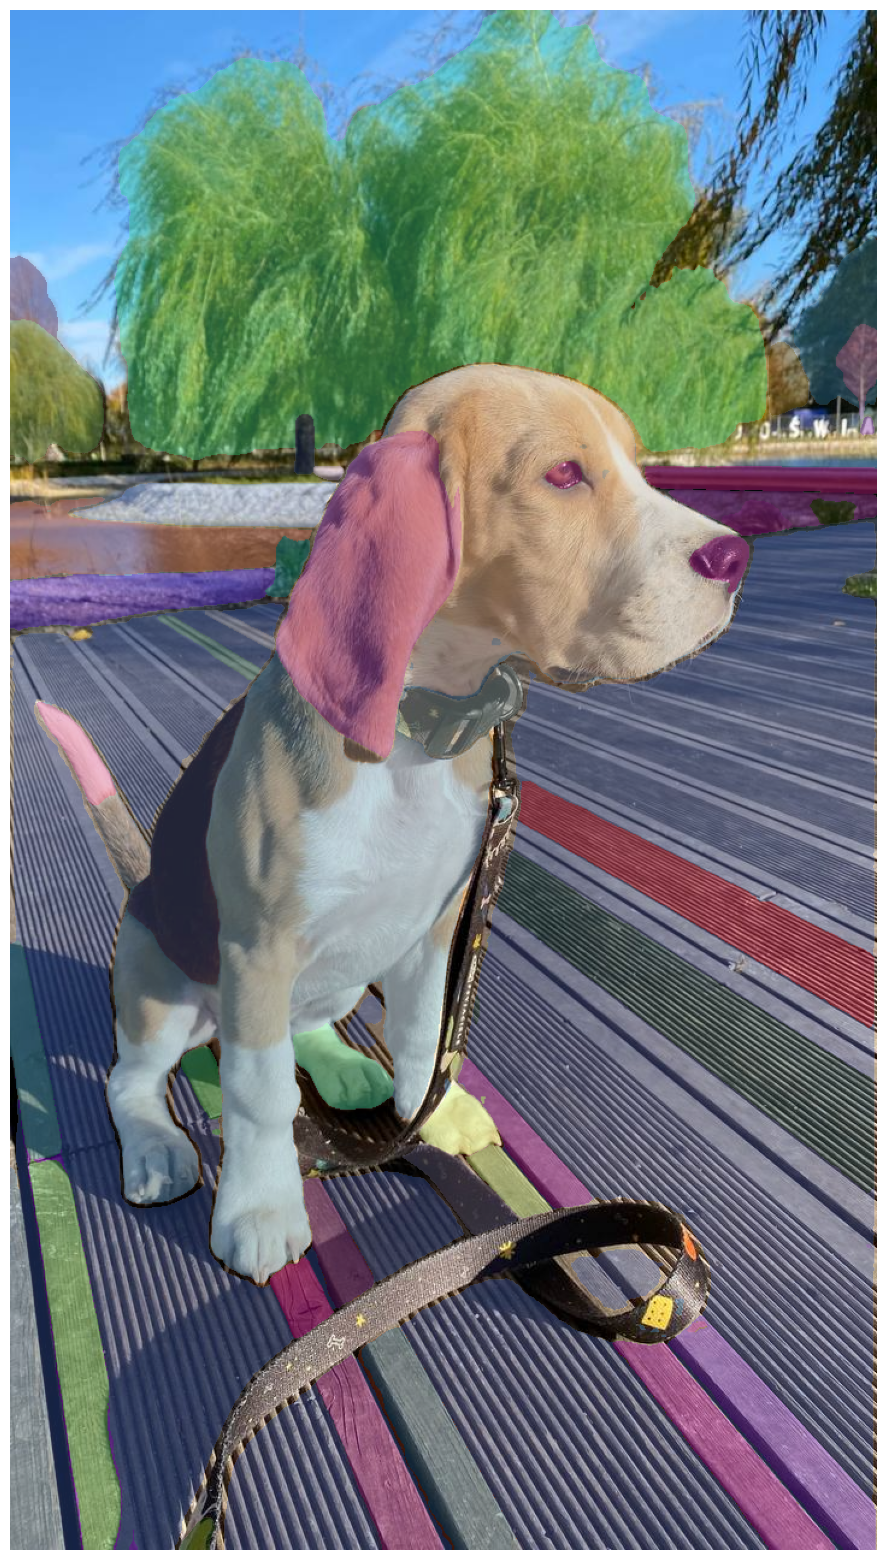

In [76]:
mask_generator = SamAutomaticMaskGenerator(sam)
mask = mask_generator.generate(image)

plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(mask)
plt.axis('off')
plt.show()

In [80]:
image = cv2.imread(image_path)
predictor = SamPredictor(sam)
predictor.set_image(image)

# Initialize a combined mask
combined_mask = np.zeros((image.shape[0], image.shape[1], 3))

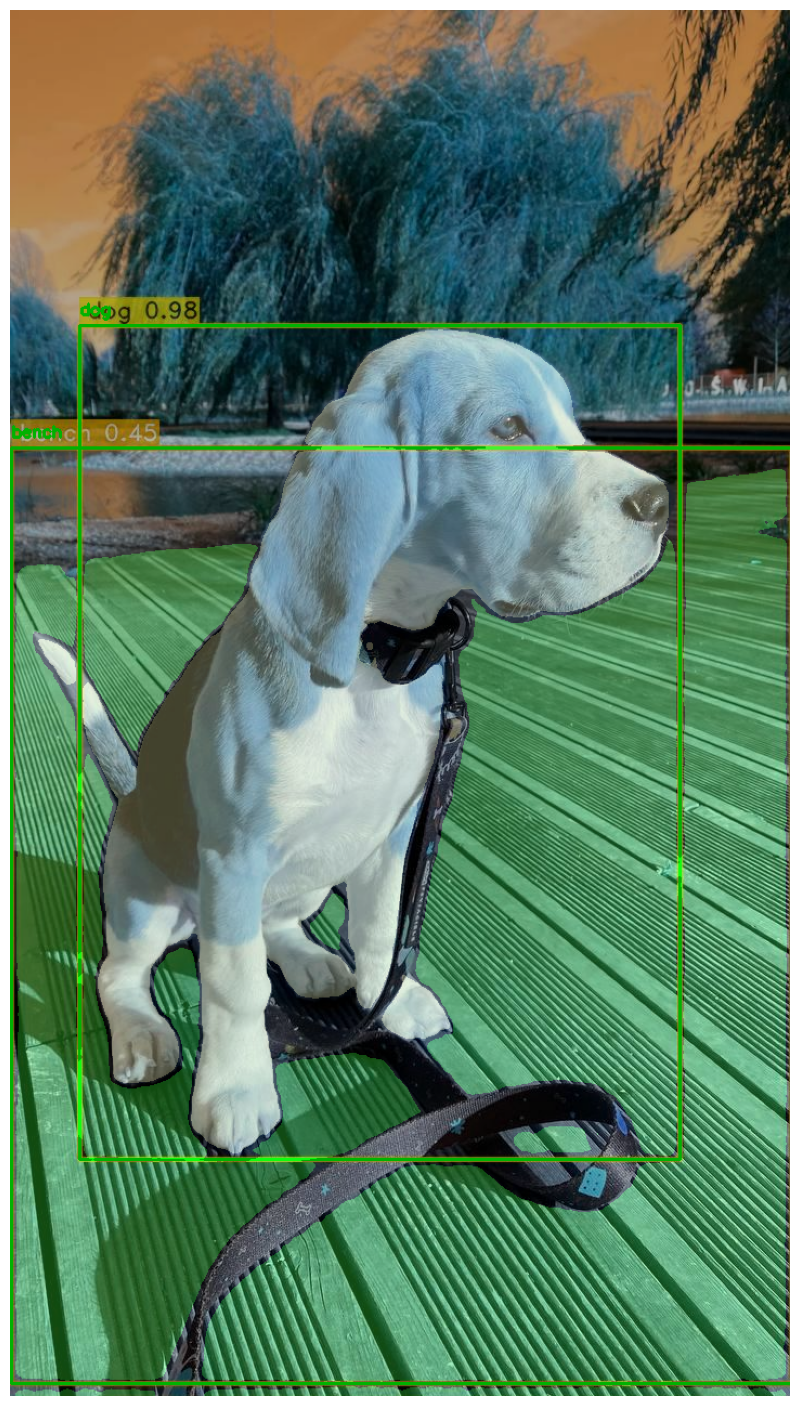

In [81]:
for i, label in enumerate(labels):
    input_box = np.array(bboxes_xyxy[i])

    # Predict mask using SAM
    mask, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box[None, :],
        multimask_output=False
    )

    # Get the correct class label
    cls = int(label)
    class_name = classNames[cls]

    # Draw bounding box
    x_min, y_min, x_max, y_max = input_box
    cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

    # Add label
    cv2.putText(image, class_name, (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Generate random color for mask
    random_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    mask_color = np.array(random_color)

    # Add the mask to the combined mask with the random color
    combined_mask += mask[0][..., None] * mask_color

# Overlay the original image with the combined mask
final_image = cv2.addWeighted(image, 0.7, combined_mask.astype(np.uint8), 0.3, 0)

# Display the image
plt.figure(figsize=(18, 18))
plt.imshow(final_image)
plt.axis('off')
plt.show()
